In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
import torch.optim as optim


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/NVL Historical Data 2018.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [3]:
df1=df.reset_index()['Price']
df1.head()

0    27815
1    28410
2    28707
3    28962
4    29556
Name: Price, dtype: int64

In [4]:
df1

0       27815
1       28410
2       28707
3       28962
4       29556
        ...  
1547    16700
1548    16500
1549    16550
1550    17100
1551    17100
Name: Price, Length: 1552, dtype: int64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
test_size

155

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
X_train.shape

(1295, 100)

In [11]:
# Tạo Dataset cho PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Định nghĩa mô hình ResNetLSTM
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNetLSTM(Module):
    def __init__(self, c_in, c_out, lstm_hidden_units=50, num_lstm_layers=1):
        super().__init__()
        nf = 64
        kss = [7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.lstm = nn.LSTM(nf * 2, lstm_hidden_units, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = x.transpose(1, 2)  # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Lấy đầu ra của LSTM ở bước thời gian cuối cùng
        x = self.fc(x)
        return x

In [13]:
# Khởi tạo mô hình
model = ResNetLSTM(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Huấn luyện mô hình
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/30, Loss: 0.0021603249479085207, Test Loss: 0.0021603249479085207
Epoch 2/30, Loss: 0.0014747704844921827, Test Loss: 0.0014747704844921827
Epoch 3/30, Loss: 0.0005411492311395705, Test Loss: 0.0005411492311395705
Epoch 4/30, Loss: 0.0007262286962941289, Test Loss: 0.0007262286962941289
Epoch 5/30, Loss: 0.0009080017916858196, Test Loss: 0.0009080017916858196
Epoch 6/30, Loss: 0.00046590910642407835, Test Loss: 0.00046590910642407835
Epoch 7/30, Loss: 1.9809074728982523e-05, Test Loss: 1.9809074728982523e-05
Epoch 8/30, Loss: 0.000687519321218133, Test Loss: 0.000687519321218133
Epoch 9/30, Loss: 2.661866892594844e-05, Test Loss: 2.661866892594844e-05
Epoch 10/30, Loss: 0.00040572264697402716, Test Loss: 0.00040572264697402716
Epoch 11/30, Loss: 2.265499824716244e-05, Test Loss: 2.265499824716244e-05
Epoch 12/30, Loss: 0.0006060932064428926, Test Loss: 0.0006060932064428926
Epoch 13/30, Loss: 4.7736197302583605e-05, Test Loss: 4.7736197302583605e-05
Epoch 14/30, Loss: 0.0001126

In [15]:
# Dự báo dữ liệu test
model.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [16]:
# Dự báo 30 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output.extend(yhat.detach().numpy().tolist())

lst_output = scaler.inverse_transform(lst_output)

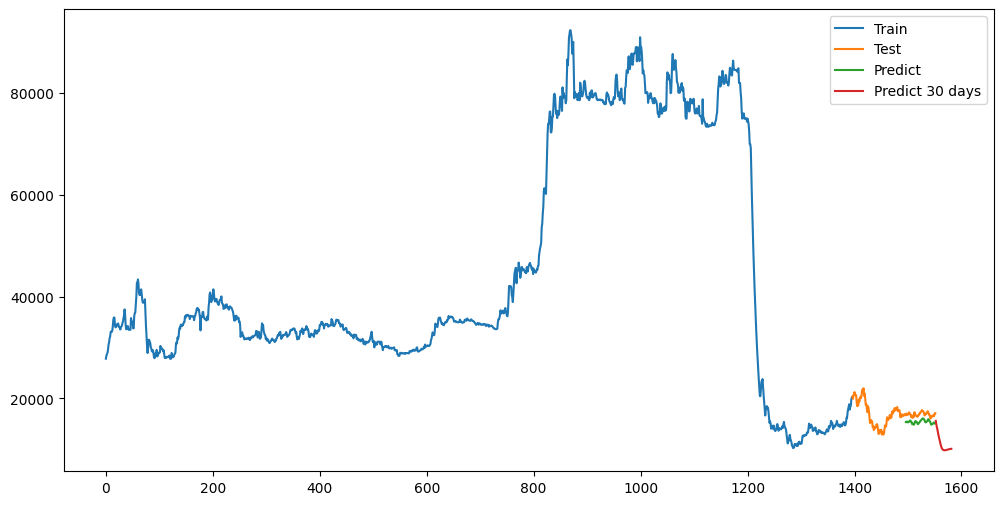

In [17]:
# Vẽ hình
plt.figure(figsize=(12, 6))
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()